In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertTokenizerFast, BertModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
from itertools import islice
import os
import ast
import json
import spacy
import time
from spacy.training import Example
from spacy.tokens import DocBin
from sklearn.metrics import classification_report

In [122]:
# Загрузка данных
df_sorption = pd.read_csv('data/Solvent_Sorption_NCOMMS/ML_uptake_sorption_extended.csv')
df_diffusivity = pd.read_csv('data/Solvent_Diffusivity_NCOMMS/ML_Diffusivity_extended.csv')

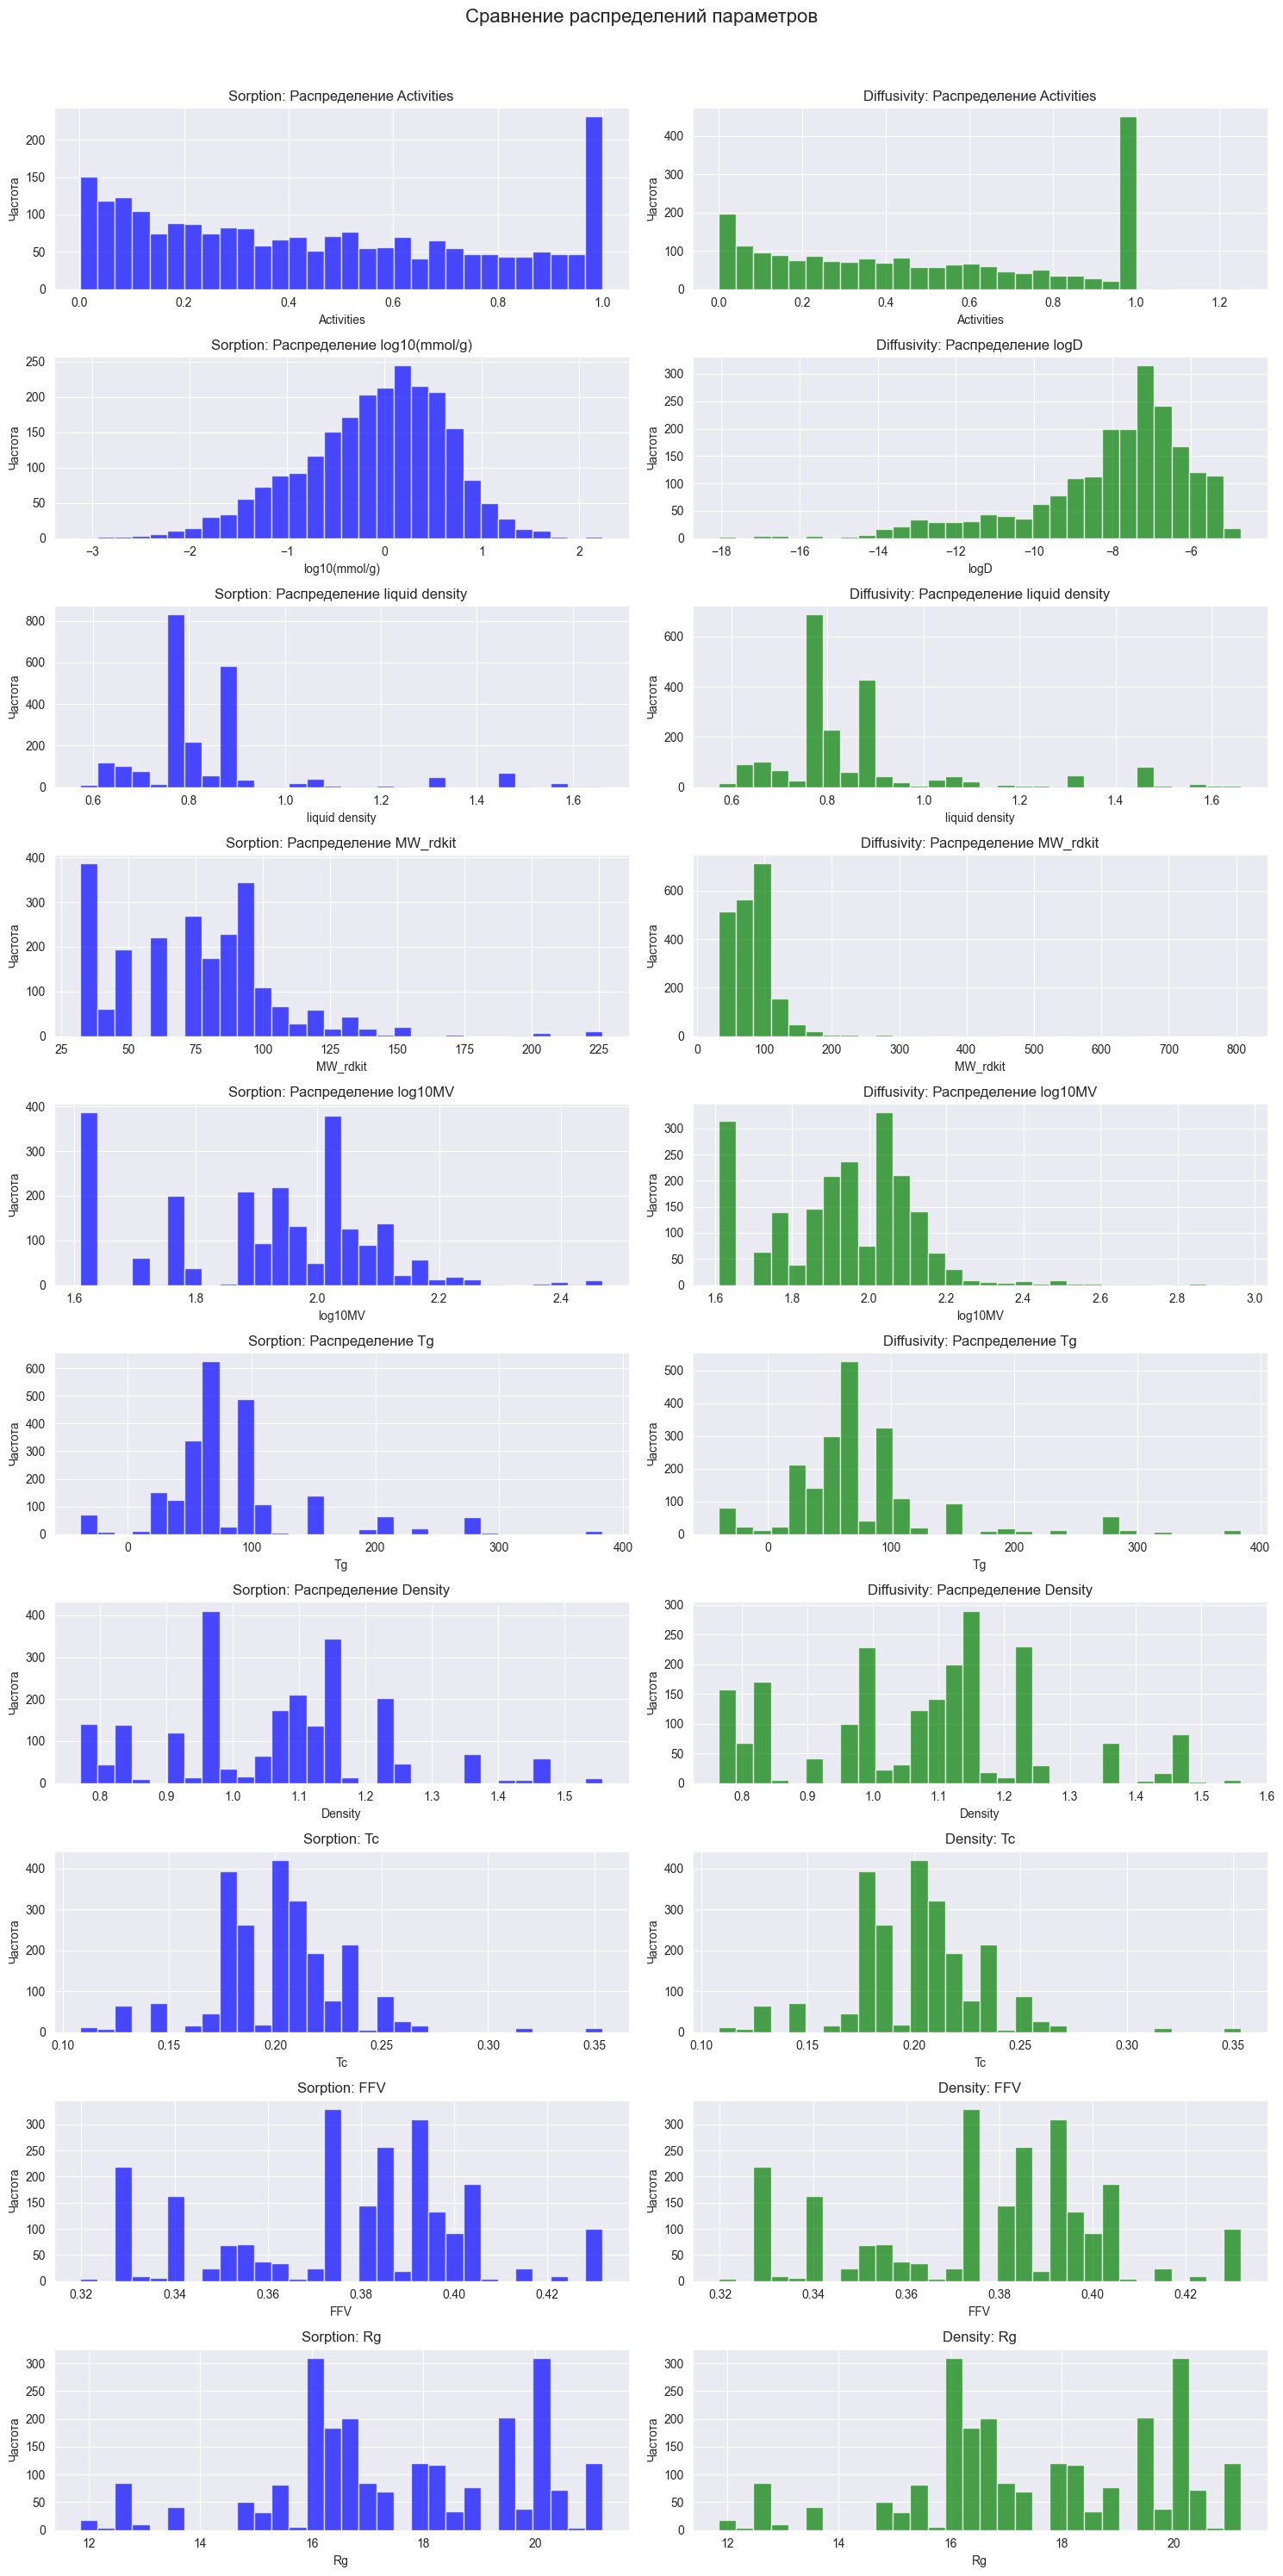

In [123]:
# Создаем фигуру с 7 строками и 2 столбцами
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(15, 30))

# Общие настройки для всех графиков
plt.suptitle('Сравнение распределений параметров', fontsize=16, y=0.995)

# --- ЛЕВЫЙ СТОЛБЕЦ (SORPTION - СИНИЙ) ---
# Activities
axes[0, 0].hist(df_sorption['Activities'], bins=30, color='blue', alpha=0.7)
axes[0, 0].set_title('Sorption: Распределение Activities')
axes[0, 0].set_xlabel('Activities')
axes[0, 0].set_ylabel('Частота')

# Sorption Values
axes[1, 0].hist(df_sorption['log10(mmol_solvent/g_Polymer)'], bins=30, color='blue', alpha=0.7)
axes[1, 0].set_title('Sorption: Распределение log10(mmol/g)')
axes[1, 0].set_xlabel('log10(mmol/g)')
axes[1, 0].set_ylabel('Частота')

# Liquid density
axes[2, 0].hist(df_sorption['liquid_density_solvent'], bins=30, color='blue', alpha=0.7)
axes[2, 0].set_title('Sorption: Распределение liquid density')
axes[2, 0].set_xlabel('liquid density')
axes[2, 0].set_ylabel('Частота')

# MW_rdkit
axes[3, 0].hist(df_sorption['MW_rdkit'], bins=30, color='blue', alpha=0.7)
axes[3, 0].set_title('Sorption: Распределение MW_rdkit')
axes[3, 0].set_xlabel('MW_rdkit')
axes[3, 0].set_ylabel('Частота')

# log10MV
axes[4, 0].hist(df_sorption['log10MV'], bins=30, color='blue', alpha=0.7)
axes[4, 0].set_title('Sorption: Распределение log10MV')
axes[4, 0].set_xlabel('log10MV')
axes[4, 0].set_ylabel('Частота')

# Tg
axes[5, 0].hist(df_sorption['Tg'], bins=30, color='blue', alpha=0.7)
axes[5, 0].set_title('Sorption: Распределение Tg')
axes[5, 0].set_xlabel('Tg')
axes[5, 0].set_ylabel('Частота')

# Density
axes[6, 0].hist(df_sorption['Density'], bins=30, color='blue', alpha=0.7)
axes[6, 0].set_title('Sorption: Распределение Density')
axes[6, 0].set_xlabel('Density')
axes[6, 0].set_ylabel('Частота')

#Tc
axes[7, 0].hist(df_sorption['Tc'], bins=30, color='blue', alpha=0.7)
axes[7, 0].set_title('Sorption: Tc')
axes[7, 0].set_xlabel('Tc')
axes[7, 0].set_ylabel('Частота')

#FFV
axes[8, 0].hist(df_sorption['FFV'], bins=30, color='blue', alpha=0.7)
axes[8, 0].set_title('Sorption: FFV')
axes[8, 0].set_xlabel('FFV')
axes[8, 0].set_ylabel('Частота')

#Rg
axes[9, 0].hist(df_sorption['Rg'], bins=30, color='blue', alpha=0.7)
axes[9, 0].set_title('Sorption: Rg')
axes[9, 0].set_xlabel('Rg')
axes[9, 0].set_ylabel('Частота')

# --- ПРАВЫЙ СТОЛБЕЦ (DIFFUSIVITY - ЗЕЛЕНЫЙ) ---
# Activities
axes[0, 1].hist(df_diffusivity['Activities'], bins=30, color='green', alpha=0.7)
axes[0, 1].set_title('Diffusivity: Распределение Activities')
axes[0, 1].set_xlabel('Activities')
axes[0, 1].set_ylabel('Частота')

# Diffusivity Values
axes[1, 1].hist(df_diffusivity['logD'], bins=30, color='green', alpha=0.7)
axes[1, 1].set_title('Diffusivity: Распределение logD')
axes[1, 1].set_xlabel('logD')
axes[1, 1].set_ylabel('Частота')

# Liquid density
axes[2, 1].hist(df_diffusivity['liquid_density_solvent'], bins=30, color='green', alpha=0.7)
axes[2, 1].set_title('Diffusivity: Распределение liquid density')
axes[2, 1].set_xlabel('liquid density')
axes[2, 1].set_ylabel('Частота')

# MW_rdkit
axes[3, 1].hist(df_diffusivity['MW_rdkit'], bins=30, color='green', alpha=0.7)
axes[3, 1].set_title('Diffusivity: Распределение MW_rdkit')
axes[3, 1].set_xlabel('MW_rdkit')
axes[3, 1].set_ylabel('Частота')

# log10MV
axes[4, 1].hist(df_diffusivity['log10MV'], bins=30, color='green', alpha=0.7)
axes[4, 1].set_title('Diffusivity: Распределение log10MV')
axes[4, 1].set_xlabel('log10MV')
axes[4, 1].set_ylabel('Частота')

# Tg
axes[5, 1].hist(df_diffusivity['Tg'], bins=30, color='green', alpha=0.7)
axes[5, 1].set_title('Diffusivity: Распределение Tg')
axes[5, 1].set_xlabel('Tg')
axes[5, 1].set_ylabel('Частота')

# Density
axes[6, 1].hist(df_diffusivity['Density'], bins=30, color='green', alpha=0.7)
axes[6, 1].set_title('Diffusivity: Распределение Density')
axes[6, 1].set_xlabel('Density')
axes[6, 1].set_ylabel('Частота')

#Tc
axes[7, 1].hist(df_sorption['Tc'], bins=30, color='green', alpha=0.7)
axes[7, 1].set_title('Density: Tc')
axes[7, 1].set_xlabel('Tc')
axes[7, 1].set_ylabel('Частота')

#FFV
axes[8, 1].hist(df_sorption['FFV'], bins=30, color='green', alpha=0.7)
axes[8, 1].set_title('Density: FFV')
axes[8, 1].set_xlabel('FFV')
axes[8, 1].set_ylabel('Частота')

#Rg
axes[9, 1].hist(df_sorption['Rg'], bins=30, color='green', alpha=0.7)
axes[9, 1].set_title('Density: Rg')
axes[9, 1].set_xlabel('Rg')
axes[9, 1].set_ylabel('Частота')

# Настройки отображения
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Оставляем место для общего заголовка
plt.show()

In [124]:
# Проверка данных перед обработкой
def check_data_quality(df, df_name):
    print(f"\n{'='*50}")
    print(f"Проверка данных для {df_name}")
    print(f"Всего строк: {len(df)}")
    
    # Проверка основных колонок
    columns_to_check = [
        'log10(mmol_solvent/g_Polymer)', 
        'logD',
        'liquid_density_solvent',
        'MW_rdkit',
        'log10MV',
        'Activities'
    ]
    
    for col in columns_to_check:
        if col in df.columns:
            nan_count = df[col].isna().sum()
            zero_count = (df[col] == 0).sum()
            print(f"Колонка {col}:")
            print(f"  - Пропущенных значений (NaN): {nan_count}")
            print(f"  - Нулевых значений: {zero_count}")
            if nan_count > 0:
                # Показать примеры строк с NaN
                print(f"  - Примеры строк с NaN:")
                print(df[df[col].isna()].head(2))
        else:
            print(f"⚠️ Колонка {col} отсутствует в DataFrame")

    print(f"{'='*50}\n")

In [125]:
# Проверка данных сорбции
check_data_quality(df_sorption, "Sorption Data")

# Проверка данных диффузии
check_data_quality(df_diffusivity, "Diffusivity Data")


Проверка данных для Sorption Data
Всего строк: 2275
Колонка log10(mmol_solvent/g_Polymer):
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0
⚠️ Колонка logD отсутствует в DataFrame
Колонка liquid_density_solvent:
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0
Колонка MW_rdkit:
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0
Колонка log10MV:
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0
Колонка Activities:
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0


Проверка данных для Diffusivity Data
Всего строк: 2045
⚠️ Колонка log10(mmol_solvent/g_Polymer) отсутствует в DataFrame
Колонка logD:
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0
Колонка liquid_density_solvent:
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0
Колонка MW_rdkit:
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0
Колонка log10MV:
  - Пропущенных значений (NaN): 0
  - Нулевых значений: 0
Колонка Activities:
  - Пропущенных значений (NaN): 0
  

In [126]:
def categorize_values(series, property_name):
    # Проверка на пропущенные значения
    nan_count = series.isna().sum()
    if nan_count > 0:
        print(f"⚠️ ВНИМАНИЕ: В колонке {property_name} найдено {nan_count} пропущенных значений (NaN). Они будут исключены из анализа.")
        series = series.dropna()
    
    # Проверка на единственное уникальное значение
    if series.nunique() == 1:
        print(f"⚠️ ВНИМАНИЕ: В колонке {property_name} все значения одинаковы ({series.iloc[0]}). Все данные будут отнесены к категории 'среднее'.")
        categories = pd.Series(['среднее'] * len(series), index=series.index)
        return categories, ['низкое', 'среднее', 'высокое']
    
    # Используем квантили для балансировки категорий
    low_bound = series.quantile(0.33)
    high_bound = series.quantile(0.67)
    
    # Создание категорий
    bins = [-np.inf, low_bound, high_bound, np.inf]
    labels = ['низкое', 'среднее', 'высокое']
    categories = pd.cut(series, bins=bins, labels=labels)
    
    # Проверка баланса категорий
    value_counts = categories.value_counts().sort_index()
    total = len(categories)
    
    # Вывод информации
    print(f"Диапазон значений для '{property_name}': {series.min():.4f} - {series.max():.4f}")
    print(f"Пороги категорий: низкое <= {low_bound:.4f}, среднее <= {high_bound:.4f}, высокое > {high_bound:.4f}")
    print(f"Распределение категорий: низкое={value_counts['низкое']} ({value_counts['низкое']/total:.1%}), "
          f"среднее={value_counts['среднее']} ({value_counts['среднее']/total:.1%}), "
          f"высокое={value_counts['высокое']} ({value_counts['высокое']/total:.1%})")
    
    return categories, labels

# Определяем колонки для обработки
common_columns = ['Activities', 'liquid_density_solvent', 'MW_rdkit', 'log10MV', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
sorption_specific = ['log10(mmol_solvent/g_Polymer)']
diffusivity_specific = ['logD']

In [127]:
# Применяем категоризацию ко всем колонкам в df_sorption
for col in common_columns + sorption_specific:
    if col in df_sorption.columns:
        print(f"\nОбработка колонки '{col}' в df_sorption:")
        values = df_sorption[col]
        categories, labels = categorize_values(values, f'sorption: {col}')
        df_sorption[f'{col}_category'] = categories
        
        # Проверка распределения категорий
        print("Распределение категорий:")
        print(df_sorption[f'{col}_category'].value_counts(dropna=False))
    else:
        print(f"⚠️ Колонка '{col}' отсутствует в df_sorption")


Обработка колонки 'Activities' в df_sorption:
Диапазон значений для 'sorption: Activities': 0.0013 - 1.0000
Пороги категорий: низкое <= 0.2365, среднее <= 0.6137, высокое > 0.6137
Распределение категорий: низкое=751 (33.0%), среднее=773 (34.0%), высокое=751 (33.0%)
Распределение категорий:
Activities_category
среднее    773
низкое     751
высокое    751
Name: count, dtype: int64

Обработка колонки 'liquid_density_solvent' в df_sorption:
Диапазон значений для 'sorption: liquid_density_solvent': 0.5730 - 1.6620
Пороги категорий: низкое <= 0.7870, среднее <= 0.8650, высокое > 0.8650
Распределение категорий: низкое=1154 (50.7%), среднее=639 (28.1%), высокое=482 (21.2%)
Распределение категорий:
liquid_density_solvent_category
низкое     1154
среднее     639
высокое     482
Name: count, dtype: int64

Обработка колонки 'MW_rdkit' в df_sorption:
Диапазон значений для 'sorption: MW_rdkit': 32.0420 - 226.4480
Пороги категорий: низкое <= 58.1240, среднее <= 90.0780, высокое > 90.0780
Распределен

In [128]:
# Применяем категоризацию ко всем колонкам в df_diffusivity
for col in common_columns + diffusivity_specific:
    if col in df_diffusivity.columns:
        print(f"\nОбработка колонки '{col}' в df_diffusivity:")
        values = df_diffusivity[col]
        categories, labels = categorize_values(values, f'diffusivity: {col}')
        df_diffusivity[f'{col}_category'] = categories
        
        # Проверка распределения категорий
        print("Распределение категорий:")
        print(df_diffusivity[f'{col}_category'].value_counts(dropna=False))
    else:
        print(f"⚠️ Колонка '{col}' отсутствует в df_diffusivity")


Обработка колонки 'Activities' в df_diffusivity:
Диапазон значений для 'diffusivity: Activities': 0.0000 - 1.2515
Пороги категорий: низкое <= 0.2576, среднее <= 0.7029, высокое > 0.7029
Распределение категорий: низкое=675 (33.0%), среднее=695 (34.0%), высокое=675 (33.0%)
Распределение категорий:
Activities_category
среднее    695
низкое     675
высокое    675
Name: count, dtype: int64

Обработка колонки 'liquid_density_solvent' в df_diffusivity:
Диапазон значений для 'diffusivity: liquid_density_solvent': 0.5730 - 1.6620
Пороги категорий: низкое <= 0.7870, среднее <= 0.8650, высокое > 0.8650
Распределение категорий: низкое=992 (48.5%), среднее=565 (27.6%), высокое=488 (23.9%)
Распределение категорий:
liquid_density_solvent_category
низкое     992
среднее    565
высокое    488
Name: count, dtype: int64

Обработка колонки 'MW_rdkit' в df_diffusivity:
Диапазон значений для 'diffusivity: MW_rdkit': 32.0420 - 807.3390
Пороги категорий: низкое <= 60.0960, среднее <= 92.1410, высокое > 92.14

In [129]:
# Глобальные конфигурационные данные (вынесены для удобства)
GENDER_SYNONYMS = {
    'm': {  # мужской род (коэффициент, радиус)
        'низкая': ['низкий', 'маленький', 'небольшой', 'скромный', 'невысокий'],
        'средняя': ['средний', 'умеренный', 'нормальный', 'стандартный'],
        'высокая': ['высокий', 'большой', 'значительный', 'превосходный', 'выдающийся']
    },
    'f': {  # женский род (активность, плотность)
        'низкая': ['низкая', 'маленькая', 'небольшая', 'скромная', 'невысокая'],
        'средняя': ['средняя', 'умеренная', 'нормальная', 'стандартная'],
        'высокая': ['высокая', 'большая', 'значительная', 'превосходная', 'выдающаяся']
    },
    'n': {  # средний род (свойство, состояние)
        'низкая': ['низкое', 'маленькое', 'небольшое', 'скромное', 'невысокое'],
        'средняя': ['среднее', 'умеренное', 'нормальное', 'стандартное'],
        'высокая': ['высокое', 'большое', 'значительное', 'превосходное', 'выдающееся']
    }
}

In [130]:
 # Расширенная конфигурация параметров
PARAM_CONFIG = {
        'Activities': {
            'gender': 'f',
            'codes': ['Tc', 'акт', 'акт-сть'],
            'names': ['активность растворителя', 'термодинамическая активность', 'активность системы'],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} уровень {name}",
                "с {adjective} {name}",
                "с {adjective} значением {name}"
            ]
        },
        'log10(mmol_solvent/g_Polymer)': {
            'gender': 'f',
            'codes': ['Sorb', 'сорб', 'емк'],
            'names': ['сорбционная емкость', 'поглощение растворителя', 'способность к сорбции'],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} способность к поглощению",
                "с {adjective} {name}",
                "с {adjective} поглощением растворителя"
            ]
        },
        'logD': {
            'gender': 'm',
            'codes': ['D', 'дифф', 'скор'],
            'names': ['коэффициент диффузии', 'скорость проникновения', 'диффузионная способность', 'диффузия', 'значение диффузии'],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} скорость диффузии",
                "с {adjective} {name}",
                "с {adjective} проникновением"
            ]
        },
        'liquid_density_solvent': {
            'gender': 'f',
            'codes': ['ρ_solv', 'пл-ть_р-ля', 'плотн'],
            'names': ['плотность растворителя', 'жидкостная плотность', 'массовая концентрация'],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} плотность растворителя",
                "с {adjective} {name}",
                "с {adjective} массовой концентрацией"
            ]
        },
        'MW_rdkit': {
            'gender': 'f',
            'codes': ['MW', 'мол.масса', 'вес'],
            'names': ['молекулярная масса', 'вес молекул', 'массовая характеристика', 'вес', 'молекулярный вес'],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} молекулярный вес",
                "с {adjective} {name}",
                "с {adjective} массовой характеристикой"
            ]
        },
        'log10MV': {
            'gender': 'm',
            'codes': ['MV', 'объем', 'мол.об'],
            'names': ['молярный объем', 'объем молекул', 'пространственная характеристика'],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} объем молекул",
                "с {adjective} {name}",
                "с {adjective} пространственной характеристикой"
            ]
        },
        'Tg': {
            'gender': 'f',
            'codes': ['Tg', 'стекл', 't_стекл'],
            'names': [
                'температура стеклования', 'температура перехода', 
                'предел стеклования', 'точка витрификации'
            ],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} температура перехода",
                "с {adjective} {name}",
                "с {adjective} точкой витрификации"
            ]
        },
        'FFV': {
            'gender': 'm',
            'codes': ['FFV', 'св.об', 'порист'],
            'names': [
                'свободный объем', 'объем пустот', 
                'пористость структуры', 'незанятый объем'
            ],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} объем пустот",
                "с {adjective} {name}",
                "с {adjective} пористостью структуры"
            ]
        },
        'Tc': {
            'gender': 'f',
            'codes': ['Tc', 'теплопр', 'конд'],
            'names': [
                'теплопроводность', 'теплопередача', 
                'термическая проводимость', 'коэффициент теплопередачи'
            ],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} теплопередача",
                "с {adjective} {name}",
                "с {adjective} термической проводимостью"
            ]
        },
        'Density': {
            'gender': 'f',
            'codes': ['ρ_pol', 'пл-ть_пол', 'плотн_пол'],
            'names': [
                'плотность полимера', 'массовая плотность', 
                'удельный вес', 'объемная масса'
            ],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} массовая плотность",
                "с {adjective} {name}",
                "с {adjective} объемной массой"
            ]
        },
        'Rg': {
            'gender': 'm',
            'codes': ['Rg', 'рад_гир', 'размер'],
            'names': [
                'радиус гирации', 'размер макромолекул', 
                'молекулярный радиус', 'гирационный параметр'
            ],
            'phrases': [
                "{adjective} {name}", 
                "{adjective} размер макромолекул",
                "с {adjective} {name}",
                "с {adjective} гирационным параметром"
            ]
        }
    }

In [131]:
# Шаблоны для начала запроса
START_PHRASES = [
        "Мне нужен полимер с {params}, чтобы {purpose}",
        "Ищу материал с {params} для {purpose}",
        "Требуется полимер с {params}, способный {purpose}",
        "Нужен состав с {params}, который {purpose}",
        "Интересует полимер с {params}, обеспечивающий {purpose}",
        "Планирую использовать материал с {params} в условиях {purpose}",
        "При выборе полимера важны {params} для решения задачи {purpose}",
        "Хочу найти полимер с {params}, так как требуется {purpose}"
    ]

In [132]:
# Цели использования
PURPOSES = [
        "выдерживать высокие нагрузки",
        "работать при экстремальных температурах",
        "сохранять форму под давлением",
        "обеспечивать надежную изоляцию",
        "работать в агрессивных средах",
        "обеспечивать долговечность конструкции",
        "минимизировать тепловые потери",
        "максимизировать эффективность процесса",
        "обеспечивать стабильность размеров",
        "снижать энергозатраты"
    ]

In [133]:
# Соединители для параметров
CONNECTORS = [
        ", а также ", ", при этом ", ", но при этом ", ", и при этом ", 
        ", дополнительно ", ", что важно ", ", что критично ", ", еще "
        ", что необходимо ", ", что требуется ", ", что важно для ", ", и ", ", который имеет "
    ]

In [134]:
def get_target_columns(property_type):
    """Определяет целевые колонки в зависимости от типа свойства"""
    if property_type == 'sorption':
        return [
            'Activities', 'log10(mmol_solvent/g_Polymer)', 
            'liquid_density_solvent', 'MW_rdkit', 'log10MV',
            'Tg', 'FFV', 'Tc', 'Density', 'Rg'
        ]
    else:
        return [
            'Activities', 'logD', 
            'liquid_density_solvent', 'MW_rdkit', 'log10MV',
            'Tg', 'FFV', 'Tc', 'Density', 'Rg'
        ]

In [135]:
def calculate_thresholds(df, target_columns):
    """Вычисляет пороги для категорий (низкая/средняя/высокая) для каждого параметра"""
    thresholds = {}
    for col in target_columns:
        if col not in df.columns:
            continue
            
        valid_values = df[col].dropna()
        if not valid_values.empty:
            low = valid_values.quantile(0.33)
            high = valid_values.quantile(0.66)
            thresholds[col] = (low, high)
    return thresholds

In [136]:
def get_value_category(value, thresholds, param):
    """Определяет категорию значения (низкая/средняя/высокая)"""
    if param not in thresholds:
        return None
        
    low, high = thresholds[param]
    if value < low:
        return 'низкая'
    elif value < high:
        return 'средняя'
    else:
        return 'высокая'

In [137]:
def generate_param_phrase(param, config, row, thresholds):
    """
    Генерирует фразу для одного параметра
    
    Возвращает:
    - phrase: сгенерированная фраза (например, "высокая теплопроводность")
    - category: категория параметра (низкая/средняя/высокая)
    """
    value = row[param]
    if pd.isna(value):
        return None, None
        
    # Определяем категорию
    category = get_value_category(value, thresholds, param)
    if not category:
        return None, None
        
    # Выбираем прилагательное с учетом рода
    gender = config['gender']
    adjective = random.choice(GENDER_SYNONYMS[gender][category])
    
    # Формируем фразу
    name = random.choice(config['names'])
    phrase_template = random.choice(config['phrases'])
    phrase = phrase_template.format(adjective=adjective, name=name)
    
    return phrase, category

In [138]:
def build_single_query_text(param_phrases, annotations):
    """Формирует текст запроса из нескольких параметров"""
    if not param_phrases:
        return None
        
    # Формируем текст запроса
    params_text = param_phrases[0]
    for i in range(1, len(param_phrases)):
        connector = random.choice(CONNECTORS)
        params_text += connector + param_phrases[i]
    
    # Добавляем цель использования
    start_phrase = random.choice(START_PHRASES)
    purpose = random.choice(PURPOSES)
    text = start_phrase.format(params=params_text, purpose=purpose)
    
    return text

In [139]:
def generate_single_query(df, thresholds, target_columns, property_type):
    """
    Генерирует один пользовательский запрос с аннотациями
    
    Возвращает:
    - text: текст запроса
    - annotations: список аннотаций
    - params_str: строка с параметрами для анализа
    """
    # Собираем все возможные параметры для случайной выборки
    all_params = [p for p in PARAM_CONFIG.keys() if p in target_columns]
    
    # Случайно выбираем количество параметров в запросе (2-5)
    num_params = random.randint(2, min(5, len(all_params)))
    selected_params = random.sample(all_params, num_params)
    
    param_phrases = []
    annotations = []
    
    # Для каждого выбранного параметра генерируем фразу
    for param in selected_params:
        # Случайно выбираем строку из датасета
        valid_rows = df[df[param].notna()]
        if valid_rows.empty:
            continue
            
        row = valid_rows.sample(1).iloc[0]
        config = PARAM_CONFIG.get(param)
        if not config:
            continue
            
        # Генерируем фразу для параметра
        phrase, category = generate_param_phrase(param, config, row, thresholds)
        if not phrase or not category:
            continue
            
        # Сохраняем информацию об аннотации
        annotations.append({
            "param": param,
            "label": category,
            "phrase": phrase,
            "code": random.choice(config['codes'])
        })
        param_phrases.append(phrase)
    
    # Если не удалось сгенерировать ни одной фразы
    if not param_phrases:
        return None, None, None
        
    # Формируем текст запроса
    text = build_single_query_text(param_phrases, annotations)
    
    # Формируем удобную строку для анализа
    params_str = "|".join([f"{ann['code']}:{ann['label']}" for ann in annotations])
    
    return text, annotations, params_str

In [140]:
def validate_dataset(df, target_columns):
    """Проверяет наличие необходимых колонок в датасете"""
    missing = [col for col in target_columns if col not in df.columns]
    if missing:
        raise ValueError(f"В датасете отсутствуют колонки: {missing}")
    return True

In [141]:
def generate_ner_dataset(df, property_type, n_samples=10000):
    """
    Генерирует датасет в формате NER для обучения модели извлечения параметров из текста
    """
    # Определяем целевые колонки
    target_columns = get_target_columns(property_type)
    
    # Проверяем наличие необходимых колонок
    validate_dataset(df, target_columns)
    
    # Вычисляем пороги для категорий
    thresholds = calculate_thresholds(df, target_columns)
    
    # Генерируем записи
    dataset = []
    
    for _ in range(n_samples):
        text, annotations, params_str = generate_single_query(
            df, thresholds, target_columns, property_type
        )
        
        # Пропускаем, если не удалось сгенерировать запрос
        if text is None:
            continue
            
        dataset.append({
            "text": text,
            "annotations": annotations,
            "params_str": params_str
        })
    
    return pd.DataFrame(dataset)

In [142]:
# Генерация датасета
sorption_dataset = generate_ner_dataset(df_sorption, 'sorption', n_samples=25000)
diffusivity_dataset = generate_ner_dataset(df_diffusivity, 'diffusivity', n_samples=25000)

# Объединение датасетов
print("Объединяем датасеты...")
full_dataset = pd.concat([sorption_dataset, diffusivity_dataset], ignore_index=True)

print(f"Сгенерировано {len(full_dataset)} примеров")
print(f"Примеры датасета:")
print(full_dataset.head())

Объединяем датасеты...
Сгенерировано 50000 примеров
Примеры датасета:
                                                text  \
0  Мне нужен полимер с низкая плотность растворит...   
1  Ищу материал с с стандартная массовой характер...   
2  Планирую использовать материал с низкая темпер...   
3  Мне нужен полимер с с средняя вес, дополнитель...   
4  Планирую использовать материал с с умеренная м...   

                                         annotations  \
0  [{'param': 'liquid_density_solvent', 'label': ...   
1  [{'param': 'MW_rdkit', 'label': 'средняя', 'ph...   
2  [{'param': 'Tg', 'label': 'низкая', 'phrase': ...   
3  [{'param': 'MW_rdkit', 'label': 'средняя', 'ph...   
4  [{'param': 'liquid_density_solvent', 'label': ...   

                                          params_str  
0  ρ_solv:низкая|MW:высокая|Rg:средняя|пл-ть_пол:...  
1  мол.масса:средняя|акт-сть:высокая|емк:высокая|...  
2  t_стекл:низкая|рад_гир:средняя|пл-ть_р-ля:низк...  
3           вес:средняя|пл-ть_пол:вы

In [143]:
def analyze_dataset(dataset, name="Dataset"):
    """Анализ сгенерированного датасета"""
    print(f"\n=== АНАЛИЗ {name} ===")
    
    # Статистика по параметрам
    param_stats = {}
    for _, row in dataset.iterrows():
        for ann in row['annotations']:
            param = ann['param']
            label = ann['label']
            if param not in param_stats:
                param_stats[param] = {'низкая': 0, 'средняя': 0, 'высокая': 0, 'total': 0}
            param_stats[param][label] += 1
            param_stats[param]['total'] += 1
    
    print("Статистика по параметрам:")
    for param, stats in param_stats.items():
        print(f"  {param}: всего {stats['total']} упоминаний")
        print(f"    низкая: {stats['низкая']} ({stats['низкая']/stats['total']*100:.1f}%)")
        print(f"    средняя: {stats['средняя']} ({stats['средняя']/stats['total']*100:.1f}%)")
        print(f"    высокая: {stats['высокая']} ({stats['высокая']/stats['total']*100:.1f}%)")

# Анализ сгенерированных датасетов
analyze_dataset(sorption_dataset, "SORPTION")
analyze_dataset(diffusivity_dataset, "DIFFUSIVITY")
analyze_dataset(full_dataset, "FULL")


=== АНАЛИЗ SORPTION ===
Статистика по параметрам:
  liquid_density_solvent: всего 8678 упоминаний
    низкая: 2213 (25.5%)
    средняя: 3274 (37.7%)
    высокая: 3191 (36.8%)
  MW_rdkit: всего 8688 упоминаний
    низкая: 2867 (33.0%)
    средняя: 2791 (32.1%)
    высокая: 3030 (34.9%)
  Rg: всего 8785 упоминаний
    низкая: 2423 (27.6%)
    средняя: 3106 (35.4%)
    высокая: 3256 (37.1%)
  Density: всего 8829 упоминаний
    низкая: 2241 (25.4%)
    средняя: 3555 (40.3%)
    высокая: 3033 (34.4%)
  Activities: всего 8772 упоминаний
    низкая: 2894 (33.0%)
    средняя: 2861 (32.6%)
    высокая: 3017 (34.4%)
  log10(mmol_solvent/g_Polymer): всего 8839 упоминаний
    низкая: 2920 (33.0%)
    средняя: 2894 (32.7%)
    высокая: 3025 (34.2%)
  Tc: всего 8826 упоминаний
    низкая: 2402 (27.2%)
    средняя: 3242 (36.7%)
    высокая: 3182 (36.1%)
  Tg: всего 8701 упоминаний
    низкая: 2758 (31.7%)
    средняя: 2780 (32.0%)
    высокая: 3163 (36.4%)
  FFV: всего 8634 упоминаний
    низкая: 25

In [144]:
def validate_dataset_quality(dataset):
    """Проверка качества сгенерированного датасета"""
    print("=== ПРОВЕРКА КАЧЕСТВА ===")
    
    # Проверка наличия всех необходимых полей
    issues = []
    
    for i, row in dataset.iterrows():
        # Проверка текста
        if not row['text'] or len(str(row['text'])) < 10:
            issues.append(f"Запись {i}: слишком короткий текст")
        
        # Проверка аннотаций
        if not row['annotations'] or len(row['annotations']) == 0:
            issues.append(f"Запись {i}: отсутствуют аннотации")
        
        # Проверка соответствия текста и аннотаций
        text = str(row['text']).lower()
        for ann in row['annotations']:
            phrase = ann['phrase'].lower()
            if phrase not in text:
                issues.append(f"Запись {i}: фраза '{phrase}' не найдена в тексте")
    
    if issues:
        print(f"Найдено {len(issues)} проблем:")
        for issue in issues[:10]:  # Показываем первые 10 проблем
            print(f"  {issue}")
    else:
        print("Качество датасета: ОК")
    
    return len(issues) == 0

# Проверка качества
validate_dataset_quality(full_dataset)

=== ПРОВЕРКА КАЧЕСТВА ===
Качество датасета: ОК


True

In [151]:
#1. CSV для общего использования
full_dataset.to_csv('data/user_request_dataset/polymer_ner_dataset.csv', index=False, encoding='utf-8')

#2. JSON для удобной работы с аннотациями (исправленная версия)
with open('data/user_request_dataset/polymer_ner_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(full_dataset.to_dict('records'), f, ensure_ascii=False, indent=2, default=str)

#3. Отдельные датасеты для каждого типа свойств
sorption_dataset.to_csv('data/user_request_dataset/polymer_sorption_dataset.csv', index=False, encoding='utf-8')
diffusivity_dataset.to_csv('data/user_request_dataset/polymer_diffusivity_dataset.csv', index=False, encoding='utf-8')

print("Датасеты успешно сохранены!")

Датасеты успешно сохранены!


In [152]:
def prepare_spacy_training_data(dataset_file):
    """Подготовка данных для обучения spaCy"""
    # Загружаем датасет
    df = pd.read_csv(dataset_file)
    
    # Создаем обучающие данные в формате spaCy
    training_data = []
    
    for _, row in df.iterrows():
        text = row['text']
        entities = []
        
        # Парсим аннотации из строки
        if 'annotations_str' in row and pd.notna(row['annotations_str']):
            try:
                # Пробуем разные форматы парсинга
                annotations = ast.literal_eval(row['annotations_str'])
            except (ValueError, SyntaxError):
                try:
                    annotations = json.loads(row['annotations_str'])
                except (json.JSONDecodeError, TypeError):
                    print(f"Не удалось распарсить аннотации: {row['annotations_str']}")
                    continue
        elif 'annotations' in row and pd.notna(row['annotations']):
            # Если есть колонка 'annotations' и она не пустая
            try:
                annotations = ast.literal_eval(row['annotations'])
            except (ValueError, SyntaxError):
                try:
                    annotations = json.loads(row['annotations'])
                except (json.JSONDecodeError, TypeError):
                    print(f"Не удалось распарсить аннотации: {row['annotations']}")
                    continue
        else:
            print("Не найдены аннотации в строке")
            continue
        
        # Проверяем, что аннотации - это список
        if not isinstance(annotations, list):
            print(f"Аннотации не являются списком: {type(annotations)}")
            continue
        
        # Создаем аннотации для spaCy
        for ann in annotations:
            if not isinstance(ann, dict):
                print(f"Аннотация не является словарем: {ann}")
                continue
                
            # Проверяем наличие необходимых ключей
            if 'phrase' not in ann or 'param' not in ann or 'label' not in ann:
                print(f"Неполные данные в аннотации: {ann}")
                continue
            
            # Находим позицию фразы в тексте
            phrase = str(ann['phrase'])
            start = text.find(phrase)
            if start != -1:
                end = start + len(phrase)
                # Создаем метку в формате PARAM_CATEGORY (например, Tc_HIGH)
                label = f"{ann['param']}_{ann['label'].upper()}"
                entities.append((start, end, label))
            else:
                print(f"Фраза '{phrase}' не найдена в тексте")
        
        if entities:
            training_data.append((text, {"entities": entities}))
    
    # Сохраняем в JSONL формате
    with open('data/user_request_dataset/spacy_training_data.jsonl', 'w', encoding='utf-8') as f:
        for text, entities_dict in training_data:
            json.dump({"text": text, "entities": entities_dict["entities"]}, f, ensure_ascii=False)
            f.write('\n')
    
    print(f"Подготовлено {len(training_data)} обучающих примеров")
    return training_data

In [153]:
# Обновленный класс датасета
class PropertyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [154]:
class OptimizedPolymerNERTrainer:
    """Оптимизированный класс для обучения NER-модели"""
    
    def __init__(self, model_name="ru_core_news_sm"):
        """Инициализация модели"""
        # Проверяем доступность GPU
        self.use_gpu = torch.cuda.is_available()
        if self.use_gpu:
            print(f"Используется GPU: {torch.cuda.get_device_name(0)}")
        else:
            print("GPU не доступен, используется CPU")
        
        try:
            self.nlp = spacy.load(model_name)
        except OSError:
            print(f"Модель {model_name} не найдена. Создаем базовую модель.")
            self.nlp = spacy.blank("ru")
        
        # Добавляем NER компонент, если его нет
        if "ner" not in self.nlp.pipe_names:
            self.ner = self.nlp.add_pipe("ner")
        else:
            self.ner = self.nlp.get_pipe("ner")
    
    def add_labels_to_ner(self, training_data):
        """Добавление меток в NER компонент"""
        for _, annotations in training_data:
            for ent in annotations.get("entities", []):
                if len(ent) >= 3:  # Убедимся, что есть метка
                    self.ner.add_label(ent[2])  # ent[2] - это метка
    
    def train_model_fast(self, training_data, n_iter=20):
        """Быстрое обучение модели (5 эпох для тестирования)"""
        print(f"Начинаем быстрое обучение ({n_iter} эпох)...")
        
        # Добавляем метки
        self.add_labels_to_ner(training_data)
        
        # Убираем другие компоненты во время обучения
        pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
        unaffected_pipes = [pipe for pipe in self.nlp.pipe_names if pipe not in pipe_exceptions]
        
        # Быстрое обучение
        with self.nlp.disable_pipes(*unaffected_pipes):  # Только обучаем NER
            # Получаем оптимизатор
            optimizer = self.nlp.begin_training()
            
            # Увеличиваем размер батча для ускорения
            batch_size = 8  # Увеличен с 4 до 8
            
            for i in range(n_iter):
                print(f"Эпоха {i+1}/{n_iter}")
                losses = {}
                random.shuffle(training_data)
                
                # Используем большие батчи для ускорения
                batches = spacy.util.minibatch(
                    training_data, 
                    size=spacy.util.compounding(8.0, 64.0, 1.001)  # Увеличен минимальный размер
                )
                
                for batch in batches:
                    examples = []
                    for text, annotations in batch:
                        doc = self.nlp.make_doc(text)
                        example = Example.from_dict(doc, annotations)
                        examples.append(example)
                    
                    # Уменьшаем drop для более стабильного обучения
                    self.nlp.update(examples, drop=0.3, losses=losses, sgd=optimizer)
                
                print(f"Потери: {losses}")
                
                # Ранний выход, если потери очень маленькие
                if losses.get('ner', 0) < 0.01:
                    print("Достигнуты минимальные потери, останавливаем обучение")
                    break
        
        return self.nlp
    
    def save_model(self, model_path):
        """Сохранение обученной модели"""
        self.nlp.to_disk(model_path)
        print(f"Модель сохранена в {model_path}")

In [149]:
from thinc.api import set_gpu_allocator, require_gpu

def optimize_gpu_usage():
    """Оптимизация использования GPU"""
    try:
        # Проверяем и включаем GPU
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name(0)}")
            
            # Включаем использование GPU в spaCy (если поддерживается)
            try:
                require_gpu(0)
                print("GPU включен для spaCy")
            except Exception as e:
                print(f"Не удалось включить GPU для spaCy: {e}")
                print("Продолжаем с CPU...")
            
            # Устанавливаем аллокатор GPU
            try:
                set_gpu_allocator("pytorch")
            except:
                pass
                
            return True
        else:
            print("GPU не доступен")
            return False
    except ImportError:
        print("PyTorch не установлен")
        return False

# Добавляем в начало обучения
optimize_gpu_usage()

GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Не удалось включить GPU для spaCy: Cannot use GPU, CuPy is not installed
Продолжаем с CPU...


True

In [155]:
def train_with_progress_monitoring():
    """Обучение с мониторингом прогресса"""
    start_time = time.time()
    
    try:
        # Подготовка данных
        training_data = prepare_spacy_training_data('data/user_request_dataset/polymer_ner_dataset.csv')
        
        if not training_data:
            print("Нет обучающих данных!")
            return None
        
        print(f"Начинаем обучение на {len(training_data)} примерах...")
        print("Это займет несколько минут...")
        
        # Создание и обучение модели
        trainer = OptimizedPolymerNERTrainer()
        model = trainer.train_model_fast(training_data, n_iter=20)
        
        # Создаем директорию для модели
        import os
        os.makedirs("models", exist_ok=True)
        
        # Сохранение модели
        trainer.save_model("models/nlp_model_fast")
        
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Обучение завершено за {training_time:.2f} секунд!")
        
        return model
        
    except Exception as e:
        print(f"Ошибка при обучении: {e}")
        import traceback
        traceback.print_exc()
        return None

# Быстрый запуск
model = train_with_progress_monitoring()

Подготовлено 50000 обучающих примеров
Начинаем обучение на 50000 примерах...
Это займет несколько минут...
Используется GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Модель ru_core_news_sm не найдена. Создаем базовую модель.
Начинаем быстрое обучение (20 эпох)...
Эпоха 1/20
Потери: {'ner': np.float32(120867.96)}
Эпоха 2/20
Потери: {'ner': np.float32(1397.4576)}
Эпоха 3/20
Потери: {'ner': np.float32(1292.8129)}
Эпоха 4/20
Потери: {'ner': np.float32(1097.3627)}
Эпоха 5/20
Потери: {'ner': np.float32(1249.4073)}
Эпоха 6/20
Потери: {'ner': np.float32(975.72125)}
Эпоха 7/20
Потери: {'ner': np.float32(1184.8279)}
Эпоха 8/20
Потери: {'ner': np.float32(632.6507)}
Эпоха 9/20
Потери: {'ner': np.float32(859.99023)}
Эпоха 10/20
Потери: {'ner': np.float32(287.12997)}
Эпоха 11/20
Потери: {'ner': np.float32(357.71176)}
Эпоха 12/20
Потери: {'ner': np.float32(2514.6877)}
Эпоха 13/20
Потери: {'ner': np.float32(183.62431)}
Эпоха 14/20
Потери: {'ner': np.float32(536.72437)}
Эпоха 15/20
Потери: {'ner': np.float32

In [156]:
class PolymerParameterExtractor:
    """Класс для извлечения параметров из пользовательских запросов"""
    
    def __init__(self, model_path="models/nlp_model_fast"):
        """Загрузка обученной модели"""
        try:
            self.nlp = spacy.load(model_path)
        except OSError:
            print("Модель не найдена. Используется базовая модель.")
            self.nlp = spacy.load("ru_core_news_sm")
    
    def extract_parameters(self, text):
        """Извлечение параметров из текста"""
        doc = self.nlp(text)
        parameters = {}
        
        for ent in doc.ents:
            # Парсим метку формата PARAM_CATEGORY
            if '_' in ent.label_:
                param, category = ent.label_.split('_', 1)
                parameters[param] = {
                    'category': category.lower(),
                    'value': ent.text,
                    'start': ent.start_char,
                    'end': ent.end_char
                }
        
        return parameters
    
    def get_parameter_info(self):
        """Получение информации о параметрах"""
        return {
            'Activities': 'активность растворителя',
            'log10(mmol_solvent/g_Polymer)': 'поглощение растворителя',
            'logD': 'коэффициент диффузии',
            'liquid_density_solvent': 'плотность растворителя',
            'MW_rdkit': 'молекулярная масса',
            'log10MV': 'молярный объем',
            'Tg': 'температура стеклования',
            'FFV': 'свободный объем',
            'Tc': 'теплопроводность',
            'Density': 'плотность полимера',
            'Rg': 'радиус гирации'
        }

# Использование
extractor = PolymerParameterExtractor()

In [157]:
class ParameterRangeConverter:
    """Класс для преобразования категорий в числовые диапазоны"""
    
    def __init__(self, training_datasets):
        """Инициализация с исходными датасетами для определения диапазонов"""
        self.thresholds = self._calculate_thresholds(training_datasets)
    
    def _calculate_thresholds(self, datasets):
        """Вычисление порогов для каждого параметра"""
        thresholds = {}
        
        # Объединяем все датасеты для вычисления глобальных порогов
        all_data = pd.concat(datasets, ignore_index=True)
        
        # Определяем параметры для каждого типа
        sorption_params = [
            'Activities', 'log10(mmol_solvent/g_Polymer)', 
            'liquid_density_solvent', 'MW_rdkit', 'log10MV',
            'Tg', 'FFV', 'Tc', 'Density', 'Rg'
        ]
        
        diffusivity_params = [
            'Activities', 'logD', 
            'liquid_density_solvent', 'MW_rdkit', 'log10MV',
            'Tg', 'FFV', 'Tc', 'Density', 'Rg'
        ]
        
        # Вычисляем пороги для всех параметров
        for param in set(sorption_params + diffusivity_params):
            if param in all_data.columns:
                valid_values = all_data[param].dropna()
                if len(valid_values) > 0:
                    low = valid_values.quantile(0.33)
                    high = valid_values.quantile(0.67)
                    thresholds[param] = {
                        'low': low,
                        'high': high,
                        'min': valid_values.min(),
                        'max': valid_values.max(),
                        'mean': valid_values.mean(),
                        'std': valid_values.std()
                    }
        
        return thresholds
    
    def get_range_for_category(self, parameter, category):
        """Получение числового диапазона для параметра и категории"""
        if parameter not in self.thresholds:
            return None
        
        param_info = self.thresholds[parameter]
        
        if category == 'низкая':
            return {
                'min': param_info['min'],
                'max': param_info['low'],
                'description': f"Низкие значения {parameter}"
            }
        elif category == 'средняя':
            return {
                'min': param_info['low'],
                'max': param_info['high'],
                'description': f"Средние значения {parameter}"
            }
        elif category == 'высокая':
            return {
                'min': param_info['high'],
                'max': param_info['max'],
                'description': f"Высокие значения {parameter}"
            }
        else:
            return None
    
    def get_detailed_recommendation(self, parameter, category):
        """Получение детальной рекомендации"""
        if parameter not in self.thresholds:
            return "Параметр не найден"
        
        param_info = self.thresholds[parameter]
        range_info = self.get_range_for_category(parameter, category)
        
        if not range_info:
            return "Неверная категория"
        
        # Форматируем значения в зависимости от порядка величины
        if abs(param_info['max'] - param_info['min']) > 100:
            min_val = f"{range_info['min']:.2f}"
            max_val = f"{range_info['max']:.2f}"
        elif abs(param_info['max'] - param_info['min']) > 1:
            min_val = f"{range_info['min']:.3f}"
            max_val = f"{range_info['max']:.3f}"
        else:
            min_val = f"{range_info['min']:.4f}"
            max_val = f"{range_info['max']:.4f}"
        
        return {
            'parameter': parameter,
            'category': category,
            'range': f"[{min_val}, {max_val}]",
            'min_value': float(range_info['min']),
            'max_value': float(range_info['max']),
            'description': range_info['description']
        }

# Инициализация конвертера
converter = ParameterRangeConverter([df_sorption, df_diffusivity])

In [158]:
class PolymerRecommendationSystem:
    """Основной класс для обработки пользовательских запросов"""
    
    def __init__(self, ner_model_path="models/nlp_model_fast", training_datasets=None):
        """Инициализация системы"""
        self.extractor = PolymerParameterExtractor(ner_model_path)
        self.converter = ParameterRangeConverter(training_datasets) if training_datasets else None
    
    def process_request(self, user_request):
        """Обработка пользовательского запроса"""
        print(f"Обработка запроса: {user_request}")
        
        # 1. Извлекаем параметры
        parameters = self.extractor.extract_parameters(user_request)
        
        if not parameters:
            return {
                "error": "Не удалось извлечь параметры из запроса",
                "extracted_text": user_request
            }
        
        # 2. Преобразуем в числовые диапазоны
        recommendations = {}
        for param, info in parameters.items():
            category = info['category']
            if self.converter:
                recommendation = self.converter.get_detailed_recommendation(param, category)
                recommendations[param] = {
                    'category': category,
                    'extracted_phrase': info['value'],
                    'recommendation': recommendation
                }
            else:
                recommendations[param] = {
                    'category': category,
                    'extracted_phrase': info['value'],
                    'recommendation': f"Для параметра {param} с категорией {category}"
                }
        
        return {
            "original_request": user_request,
            "extracted_parameters": parameters,
            "recommendations": recommendations,
            "success": True
        }
    
    def format_output(self, result):
        """Форматирование результата для вывода"""
        if not result.get('success', False):
            return f"Ошибка: {result.get('error', 'Неизвестная ошибка')}"
        
        output = []
        output.append("=== РЕКОМЕНДАЦИИ ПО ПОЛИМЕРУ ===")
        output.append(f"Запрос: {result['original_request']}")
        output.append("")
        output.append("Извлеченные параметры:")
        
        for param, info in result['recommendations'].items():
            output.append(f"  {param}:")
            output.append(f"    Категория: {info['category']}")
            output.append(f"    Извлечено: {info['extracted_phrase']}")
            if isinstance(info['recommendation'], dict):
                rec = info['recommendation']
                output.append(f"    Диапазон значений: {rec['range']}")
                output.append(f"    Описание: {rec['description']}")
            else:
                output.append(f"    Рекомендация: {info['recommendation']}")
            output.append("")
        
        return "\n".join(output)

In [159]:
def evaluate_model(model, test_data):
    """Оценка качества обученной модели"""
    # Эта функция будет реализована после обучения
    pass

def save_model_artifacts(model, converter, extractor):
    """Сохранение всех компонентов системы"""
    # Сохраняем модель spaCy
    model.nlp.to_disk("final_polymer_model")
    
    # Сохраняем конвертер с порогами
    import pickle
    with open("parameter_converter.pkl", "wb") as f:
        pickle.dump(converter.thresholds, f)
    
    print("Все компоненты системы сохранены")

In [160]:
# Создаем систему
system = PolymerRecommendationSystem(
    ner_model_path="models/nlp_model_fast",
    training_datasets=[df_sorption, df_diffusivity]
)

# Обрабатываем запрос
request = "Хочу получить полимер с низкой плотностью, большой молярной массой, низкой теплопроводностью и иметь нормальный коэффициент диффузии для производства шестеренок в двигателе"
result = system.process_request(request)
print(system.format_output(result))

Обработка запроса: Хочу получить полимер с низкой плотностью, большой молярной массой, низкой теплопроводностью и иметь нормальный коэффициент диффузии для производства шестеренок в двигателе
=== РЕКОМЕНДАЦИИ ПО ПОЛИМЕРУ ===
Запрос: Хочу получить полимер с низкой плотностью, большой молярной массой, низкой теплопроводностью и иметь нормальный коэффициент диффузии для производства шестеренок в двигателе

Извлеченные параметры:
  Tc:
    Категория: низкая
    Извлечено: низкой плотностью
    Диапазон значений: [0.1082, 0.1884]
    Описание: Низкие значения Tc

  log10MV:
    Категория: высокая
    Извлечено: большой молярной массой
    Диапазон значений: [2.027, 2.965]
    Описание: Высокие значения log10MV

  Tg:
    Категория: низкая
    Извлечено: низкой теплопроводностью и
    Диапазон значений: [-40.17, 51.55]
    Описание: Низкие значения Tg

  logD:
    Категория: средняя
    Извлечено: нормальный коэффициент диффузии
    Диапазон значений: [-8.250, -6.957]
    Описание: Средние з